In [81]:
import re
import string
import warnings
import numpy as np
import pandas as pd

import itertools
import seaborn as sns
from time import sleep
from pprint import pprint
from itertools import chain
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

import gensim
import preprocessor as pre
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
from IPython.core.display import HTML

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import spacy
import en_core_web_sm
from wordcloud import WordCloud

# Word tokenization
from spacy.lang.en import English

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('max_colwidth',500)
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
ROOT_DATA = 'D:/Statistical Programming Projects/Social Network and Sentiment Analysis/data/'

tqdm.pandas()
stop_words = set(stopwords.words('english'))
sns.set(rc={'figure.figsize':(9,6),'lines.linewidth': 5, 'lines.markersize': 10})
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid",{"font.family": ["Corbel"]})
pd.options.display.float_format = '{:20,.2f}'.format

## A. Topic Modelling

### 1. Load tweet database

In [2]:
health_tweets = pd.read_csv(ROOT_DATA+"covid_nlp_data.csv")
topic_health_tweets = health_tweets[['id','orig_tweet']]
topic_health_tweets = topic_health_tweets[~topic_health_tweets.orig_tweet.isnull()]
topic_health_tweets.reset_index(inplace=True,drop=True)
topic_health_tweets.head(5)

,id,orig_tweet
0,1255285661957054466,It's 7:00 in NYC... #FirstResponders #HealthcareWorkers #EssentialWorkers #NewYork #NY #NYC #Manhattan #MurrayHill #KipsBay #Coronavirus #Covid19 #GroupTherapyNYC @CandisLai https://t.co/EHErM8ngHb
1,1255285659704725506,The @DIIMSA Word Challenge: High School (7:00 PM - 7:05 PM CST). #DIIMSA #DIIMSAVBOARD #DIIMSACHALLENGE #SonyAlpha #ClimateChange #COVID19 #science #remotelearning #remoteworking #pandemic #ScienceWillWin https://t.co/pC82vBAehl
2,1255285472525537282,"Oxford scientists say a vaccine may be widely available by September https://t.co/lrcd48oSMU A RAY OF HOPE: In the global race to find a vaccine, Oxford University just jumped way ahead of the pack. Human testing is already underway, and scientists say they're hopeful a coronav… https://t.co/KaQ0Ulu592"
3,1255285448634773504,"@FrankDaTank223 @gatewaypundit @SecretaryCarson @PeterNavarroUSA @Larry_Kudlow @DonaldJTrumpJr If a video of doctors challenging the #COVID19 Narrative gets taken down, something very wicked is going on. The #Lockdown is causing too much havoc amongst Americans - 14:00 mark. We practically have #GreenNewDeal."
4,1255284887655010304,"China's 'boycott diplomacy' over calls for coronavirus inquiry could harm Australian exporters https://t.co/Op250SA3mS Tell the Chinese to go to hell and develop our own industries and ties to other countries. Dump them, the UN and the WHO. UN &amp; China both seek Global dominance."


### 2. prepare tweet column to analyse 

In [3]:
# HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoticons = emoticons_happy.union(emoticons_sad)

def remove_links(tweet):    
    tweet = str(tweet)
    tweet = re.sub(r'#', '', tweet) ##revome hashtags from the tweet
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                  '',tweet) #remove links from tweet
    tweet = re.sub(r'\n', ' ', tweet) ##revome next line characters from the tweet
    tweet = re.sub(r'&amp','and',tweet)
    tweet = re.sub(r'&gt;', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)]+','', tweet)#Remove symbols & pictographs
    tweet = re.sub(r'@[\w]+', '', tweet).strip()
    tweet = re.sub(r'\r', '', tweet).strip()
    return tweet

def remove_numbers(tweet):
    tweet = " ".join([word for word in tweet.split() if not word.isnumeric()])
    tweet = re.sub(r'\d{1,2}:\d{2} {0,}(pm){0,} {0,}(p\.m\.){0,} {0,}(am){0,} {0,}(a\.m\.){0,}','',tweet)
    tweet = re.sub(r'(PM){1,}|(AM){1,}|(P\.M\.){1,}|(A\.M\.){1,}','',tweet) #remove time flags
    tweet = re.sub(r'EST|BST|GMT|CST|PST|UTC|EDT','',tweet) #remove timezone codes
    tweet = " ".join([re.sub(r'^[0-9].*','',word) for word in tweet.split()])
    return tweet.strip()

def clean_tweets(tweet): 
    tweet = str(tweet)
    words = nltk.word_tokenize(tweet)
    new_words= [word for word in words if word.isalnum()]
    return " ".join(new_words)

def split_capitalised(tweet):
    bow = tweet.split()
    words = [word if word.isupper() or len(re.findall('.[^A-Z]{1,}[a-z]+',word))==0  else " ".join(re.findall('.[^A-Z]{1,}[a-z]+', word)) for word in bow]
    return " ".join(words)


print("\nRemove links and symbols from tweet")
topic_health_tweets['clean_tweet'] = topic_health_tweets.orig_tweet.progress_apply(remove_links)
print("\nRemove numbers from tweet")
topic_health_tweets['simplified_tweet'] = topic_health_tweets.clean_tweet.progress_apply(remove_numbers)
print("\nRemove punctuations and emojis from tweet")
topic_health_tweets['filtered_tweet'] = topic_health_tweets.simplified_tweet.progress_apply(clean_tweets)
print("\nRemove punctuations and emojis from tweet")
topic_health_tweets['sentence_tweet'] = topic_health_tweets.filtered_tweet.progress_apply(split_capitalised)


Remove links and symbols from tweet




Remove numbers from tweet




Remove punctuations and emojis from tweet




Remove punctuations and emojis from tweet


In [96]:
topic_health_tweets.head(10)

,id,orig_tweet,clean_tweet,simplified_tweet,filtered_tweet,sentence_tweet,ReportTestStaySafeWork,DailyUpdateDeathLiveWebinar,CasesPeopleDiedDetailGlobalNeed,GetPublicWorkerDeathsOutbreak,CasesDeathConfirmedNewUpdate,WebinarJoinLiveRegisterImpactWorkLearn,JoinFutureDiscussCrisisLink,KeyTopic
0,1255285661957054466,It's 7:00 in NYC... #FirstResponders #HealthcareWorkers #EssentialWorkers #NewYork #NY #NYC #Manhattan #MurrayHill #KipsBay #Coronavirus #Covid19 #GroupTherapyNYC @CandisLai https://t.co/EHErM8ngHb,It's 7:00 in NYC... FirstResponders HealthcareWorkers EssentialWorkers NewYork NY NYC Manhattan MurrayHill KipsBay Coronavirus Covid19 GroupTherapyNYC,It's in NYC... FirstResponders HealthcareWorkers EssentialWorkers NewYork NY NYC Manhattan MurrayHill KipsBay Coronavirus Covid19 GroupTherapyNYC,It in NYC FirstResponders HealthcareWorkers EssentialWorkers NewYork NY NYC Manhattan MurrayHill KipsBay Coronavirus Covid19 GroupTherapyNYC,It in NYC First Responders Healthcare Workers Essential Workers New York NY NYC Manhattan Murray Hill Kips Bay Coronavirus Covid Group Therapy,0.05,0.05,0.05,0.71,0.05,0.05,0.05,GetPublicWorkerDeathsOutbreak
1,1255285659704725506,The @DIIMSA Word Challenge: High School (7:00 PM - 7:05 PM CST). #DIIMSA #DIIMSAVBOARD #DIIMSACHALLENGE #SonyAlpha #ClimateChange #COVID19 #science #remotelearning #remoteworking #pandemic #ScienceWillWin https://t.co/pC82vBAehl,The Word Challenge: High School 7:00 PM - 7:05 PM CST. DIIMSA DIIMSAVBOARD DIIMSACHALLENGE SonyAlpha ClimateChange COVID19 science remotelearning remoteworking pandemic ScienceWillWin,The Word Challenge: High School - . DIIMSA DIIMSAVBOARD DIIMSACHALLENGE SonyAlpha ClimateChange COVID19 science remotelearning remoteworking pandemic ScienceWillWin,The Word Challenge High School DIIMSA DIIMSAVBOARD DIIMSACHALLENGE SonyAlpha ClimateChange COVID19 science remotelearning remoteworking pandemic ScienceWillWin,The Word Challenge High School DIIMSA DIIMSAVBOARD DIIMSACHALLENGE Sony Alpha Climate Change COVID19 science remotelearning remoteworking pandemic Science Will Win,0.02,0.02,0.02,0.42,0.02,0.02,0.50,JoinFutureDiscussCrisisLink
2,1255285472525537282,"Oxford scientists say a vaccine may be widely available by September https://t.co/lrcd48oSMU A RAY OF HOPE: In the global race to find a vaccine, Oxford University just jumped way ahead of the pack. Human testing is already underway, and scientists say they're hopeful a coronav… https://t.co/KaQ0Ulu592","Oxford scientists say a vaccine may be widely available by September A RAY OF HOPE: In the global race to find a vaccine, Oxford University just jumped way ahead of the pack. Human testing is already underway, and scientists say they're hopeful a coronav…","Oxford scientists say a vaccine may be widely available by September A RAY OF HOPE: In the global race to find a vaccine, Oxford University just jumped way ahead of the pack. Human testing is already underway, and scientists say they're hopeful a coronav…",Oxford scientists say a vaccine may be widely available by September A RAY OF HOPE In the global race to find a vaccine Oxford University just jumped way ahead of the pack Human testing is already underway and scientists say they hopeful a,Oxford scientists say a vaccine may be widely available by September A RAY OF HOPE In the global race to find a vaccine Oxford University just jumped way ahead of the pack Human testing is already underway and scientists say they hopeful a,0.01,0.01,0.01,0.01,0.01,0.01,0.95,JoinFutureDiscussCrisisLink
3,1255285448634773504,"@FrankDaTank223 @gatewaypundit @SecretaryCarson @PeterNavarroUSA @Larry_Kudlow @DonaldJTrumpJr If a video of doctors challenging the #COVID19 Narrative gets taken down, something very wicked is going on. The #Lockdown is causing too much havoc amongst Americans - 14:00 mark. We practically have #GreenNewDeal.","If a video of doctors challenging the COVID19 Narrative gets taken down, something very wicked is going on. The Lockdown is causing 

### 3. Here comes SpaCy

In [5]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])# Do lemmatization keeping only noun, adj, vb, adv

# My list of stop words.
custom_stop_list = set(['covid','covid19','coronavirus','cov19','covid-19','cov-19','covidー','corona','april','apr','may','pandemic','india','trump'])

spacy_stopwords = spacy_stopwords.union(custom_stop_list)

my_stop_words = stop_words.union(custom_stop_list)


# Create our list of punctuation marks
punctuations = string.punctuation

def remove_stopwords(texts):
    print("\nPreprocess tweet data")
    return [[word for word in simple_preprocess(str(doc)) if word not in my_stop_words] for doc in tqdm(texts)]

def make_bigrams(tweets):
    print("\nMake bigrams of tweet data")
    return [bigram_mod[tweet] for tweet in tqdm(tweets)]

def make_trigrams(tweet):
    print("\nMake trigrams of tweet data")
    return [trigram_mod[bigram_mod[tweet]] for tweet in tqdm(tweets)]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    print("\nLematize tweet data")
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### How many topics to use?

In [6]:
data_words = topic_health_tweets['sentence_tweet'].values.tolist()
data_words_nostops = remove_stopwords(data_words) # Remove Stop Words
#data_words_bigrams = make_bigrams(data_words_nostops)# Form Bigrams
bigram = gensim.models.Phrases(data_words_nostops,min_count=3,threshold=40) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = make_bigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Build the bigram and trigram models
# bigram = gensim.models.Phrases(tweet_corpus,min_count=5,threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[tweet_corpus],threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)
# data_words_bigrams = [make_bigrams(tweet) for tweet in data_tweets_lemmatized]
# data_words_trigrams = [make_trigrams(tweet) for tweet in data_tweets_lemmatized]


Preprocess tweet data




Make bigrams of tweet data




Lematize tweet data


In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Term Document Frequency
corpus = [id2word.doc2bow(tweet) for tweet in data_lemmatized]

In [8]:
def compute_coherence_values(corpus, dictionary, k):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           eval_every = 1,
                                           #alpha='auto',
                                           #eta=b,
                                           workers=7, #Logical processors-1
                                           minimum_probability=0,
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')    
    return coherence_model_lda.get_coherence()

try:
    model_results_plt = pd.read_csv(ROOT_DATA+"lda_tuning_results.csv")
except FileNotFoundError:
    # supporting function    
    grid = {}
    grid['Validation_Set'] = {}
    # Topics range
    min_topics = 2
    max_topics = 11
    step_size = 1
    topics_range = range(min_topics, max_topics, step_size)
    # Alpha parameter
    #alpha = list(np.arange(0.01, 1, 0.19))
    #alpha.append('symmetric')
    #alpha.append('asymmetric')
    # Beta parameter
    #beta = list(np.arange(0.01, 1, 0.19))
    #beta.append('symmetric')
    # Validation sets
    num_of_docs = len(corpus)
    corpus_sets = [gensim.utils.ClippedCorpus(corpus, round(num_of_docs*0.55)),
                   gensim.utils.ClippedCorpus(corpus, round(num_of_docs*0.7)), 
                   gensim.utils.ClippedCorpus(corpus, round(num_of_docs*0.85)), 
                   corpus]
    corpus_title = ['55% Corpus','70% Corpus','85% Corpus','100% Corpus']

    model_results = {'Validation_Set': [],
                     'Topics': [],
                     #'Alpha': [],
                     #'Beta': [],
                     'Coherence': []
                    }
    # Hyperparameters
    hyper = [list(range(0,len(corpus_sets),1)),topics_range]
    hyper = list(itertools.product(*hyper))

    # Can take a long time to run
    print("Best hyper-parameters for the model")
    for param in tqdm(hyper):
        sleep(0.01)                  
        cv = compute_coherence_values(corpus=corpus_sets[param[0]]
                                      ,dictionary=id2word 
                                      ,k=param[1] 
                                      #a=param[2], 
                                      #b=param[3]
                                     )
        # Save the model results
        model_results['Validation_Set'].append(corpus_title[param[0]])
        model_results['Topics'].append(param[1])
        #model_results['Alpha'].append(param[2])
        #model_results['Beta'].append(param[3])
        model_results['Coherence'].append(cv)

    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    model_results_plt = pd.DataFrame(model_results)

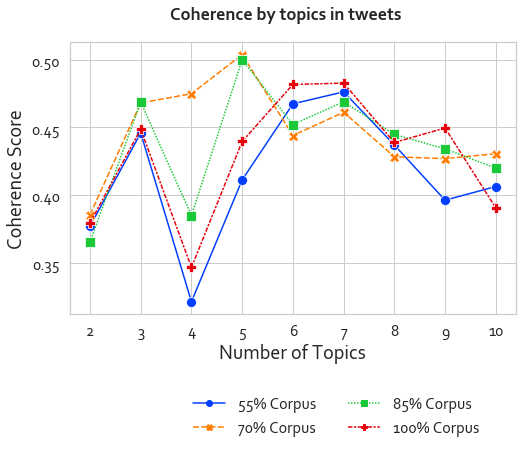

In [9]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
fig.suptitle("Coherence by topics in tweets",weight='bold').set_fontsize('18')
    
axs = sns.lineplot(x="Topics",
                  y="Coherence",
                  ci=None,
                  hue="Validation_Set",
                  palette=sns.color_palette("bright", 4),
                  style="Validation_Set",
                  markers=True,
                  markersize=10,
                  data=model_results_plt)

axs.set_xlabel('Number of Topics',fontsize=20)
axs.set_ylabel('Coherence Score',fontsize=20)
handles, labels = axs.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:],fontsize=16,ncol=2, bbox_to_anchor=(.95, -0.25))
for lh in axs.legend_.legendHandles: 
    lh._sizes = [100]
plt.show()

In [10]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, #Set based on the coherence score of graph above
                                           #alpha='auto',
                                           #eta=0.96,
                                           random_state=100,
                                           chunksize=1000,
                                           passes=10,
                                           workers=7, #Logical cores -1 
                                           eval_every = 1,
                                           minimum_probability=0,
                                           per_word_topics=True)

In [41]:
# Prints the top topics.
for top in lda_model.print_topics():
    print(top)

(0, '0.009*"say" + 0.008*"test" + 0.008*"stay_safe" + 0.007*"work" + 0.007*"people" + 0.007*"virus" + 0.006*"testing" + 0.006*"need" + 0.006*"go" + 0.006*"make"')
(1, '0.036*"join" + 0.028*"webinar" + 0.027*"update" + 0.015*"today" + 0.013*"free" + 0.012*"live" + 0.011*"register" + 0.010*"death" + 0.010*"time" + 0.010*"tomorrow"')
(2, '0.038*"case" + 0.017*"people" + 0.009*"death" + 0.009*"number" + 0.008*"detail" + 0.008*"need" + 0.008*"say" + 0.007*"global" + 0.007*"country" + 0.007*"die"')
(3, '0.015*"get" + 0.009*"worker" + 0.008*"die" + 0.008*"public" + 0.008*"outbreak" + 0.007*"today" + 0.007*"go" + 0.007*"order" + 0.006*"health" + 0.006*"change"')
(4, '0.117*"case" + 0.047*"total" + 0.046*"death" + 0.030*"confirm" + 0.030*"new" + 0.021*"update" + 0.017*"recover" + 0.017*"report" + 0.013*"test" + 0.013*"positive"')
(5, '0.034*"join" + 0.021*"today" + 0.021*"register" + 0.018*"live" + 0.009*"impact" + 0.008*"work" + 0.008*"learn" + 0.008*"discuss" + 0.007*"time" + 0.007*"online"')

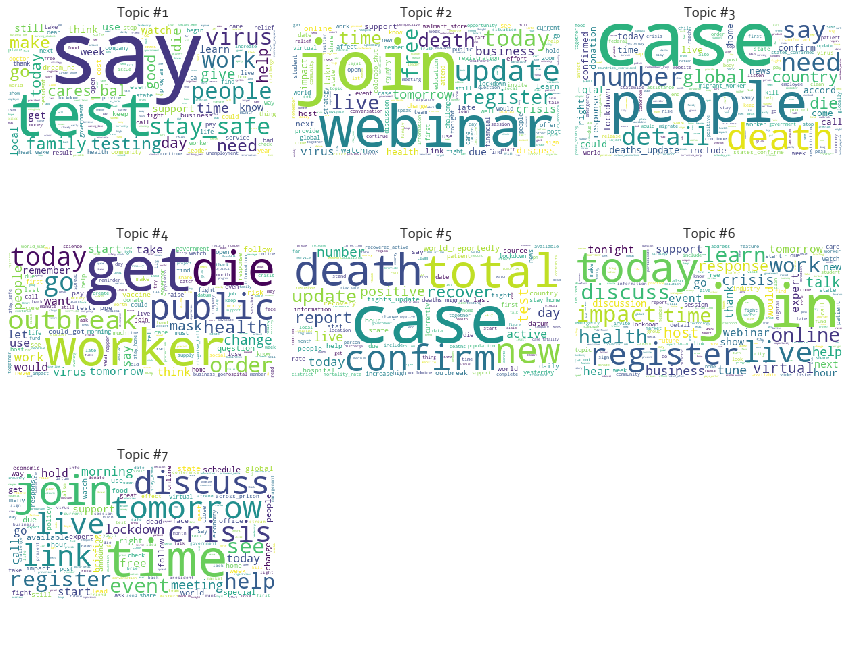

In [94]:
clouds = []
for t in range(lda_model.num_topics):
    wordcloud = WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(t, 200)))
    clouds.append(wordcloud)
    
fig, axes = plt.subplots(3,3,figsize=(15,12),gridspec_kw={'wspace':.05, 'hspace':.05},
                           squeeze=True)
for index, axis in enumerate(axes.reshape(-1)):
    if index < 7:
        axis.imshow(clouds[index])
        axis.set_title("Topic #" + str(index+1),)
    axis.axis('off')    
fig.tight_layout()

In [31]:
tweet_topics = {0: [], 1: [], 2: [], 3: [] , 4:[], 5:[], 6:[]} #Based on number of topics included
def get_tweet_topics(i):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    top_topics = dict(top_topics)
    {key: value.append(top_topics[key]) for key, value in tweet_topics.items()}
    return True
    
isDone = [get_tweet_topics(tweet_row) for tweet_row in range(len(corpus))]

tweet_topics = pd.DataFrame(tweet_topics)
tweet_topics.rename(columns={
    0:'ReportTestStaySafeWork'
    ,1:'DailyUpdateDeathLiveWebinar'    
    ,2:'CasesPeopleDiedDetailGlobalNeed'
    ,3:'GetPublicWorkerDeathsOutbreak'
    ,4:'CasesDeathConfirmedNewUpdate'
    ,5:'WebinarJoinLiveRegisterImpactWorkLearn'
    ,6:'JoinFutureDiscussCrisisLink'
},inplace=True)
tweet_topics['KeyTopic'] = tweet_topics.idxmax(axis=1)
topic_health_tweets = pd.concat([topic_health_tweets,tweet_topics],axis=1)
topic_health_tweets.tail(5)

,id,orig_tweet,clean_tweet,simplified_tweet,filtered_tweet,sentence_tweet,ReportTestStaySafeWork,DailyUpdateDeathLiveWebinar,CasesPeopleDiedDetailGlobalNeed,GetPublicWorkerDeathsOutbreak,CasesDeathConfirmedNewUpdate,WebinarJoinLiveRegisterImpactWorkLearn,JoinFutureDiscussCrisisLink,KeyTopic
13591,1232754827895197698,"8) Using the authorities created by President Trump; and in accordance with the declaration, at 5:00 p.m. EST; Sunday, February 2nd, the U.S government implemented temporary measures to increase detection &amp; containment of the coronavirus proactively. Effective February 2nd.","8 Using the authorities created by President Trump; and in accordance with the declaration, at 5:00 p.m. EST; Sunday, February 2nd, the U.S government implemented temporary measures to increase detection and; containment of the coronavirus proactively. Effective February 2nd.","Using the authorities created by President Trump; and in accordance with the declaration, at ; Sunday, February the U.S government implemented temporary measures to increase detection and; containment of the coronavirus proactively. Effective February",Using the authorities created by President Trump and in accordance with the declaration at Sunday February the government implemented temporary measures to increase detection and containment of the coronavirus proactively Effective February,Using the authorities created by President Trump and in accordance with the declaration at Sunday February the government implemented temporary measures to increase detection and containment of the coronavirus proactively Effective February,0.93,0.01,0.01,0.01,0.01,0.01,0.01,ReportTestStaySafeWork
13592,1232670623115202563,"If you have been 50/50 about whether to join #footballindex start small. Find you feet and see what works for you\r\n\r\nOnce you discover what works, then you'll be confident to invest more....and grow!! 💸📈\r\n\r\nUse my referral code for a £10 bonus when you deposit £10\r\n\r\nEnjoy FI 👍🏻 https://t.co/s3bnWMuNmH","If you have been 50/50 about whether to join footballindex start small. Find you feet and see what works for you Once you discover what works, then you'll be confident to invest more....and grow!! Use my referral code for a £10 bonus when you deposit £10 Enjoy FI","If you have been about whether to join footballindex start small. Find you feet and see what works for you Once you discover what works, then you'll be confident to invest more....and grow!! Use my referral code for a £10 bonus when you deposit £10 Enjoy FI",If you have been about whether to join footballindex start small Find you feet and see what works for you Once you discover what works then you be confident to invest more grow Use my referral code for a bonus when you deposit Enjoy FI,If you have been about whether to join footballindex start small Find you feet and see what works for you Once you discover what works then you be confident to invest more grow Use my referral code for a bonus when you deposit Enjoy FI,0.01,0.01,0.01,0.63,0.01,0.33,0.01,GetPublicWorkerDeathsOutbreak
13593,1224084877487812608,"Dr. Sara Cody, Health Officer for Santa Clara County will update the media on coronavirus at 2:00 pm, 2220 Moorpark Avenue, San Jose (courtyard, below ground)","Dr. Sara Cody, Health Officer for Santa Clara County will update the media on coronavirus at 2:00 pm, 2220 Moorpark Avenue, San Jose courtyard, below ground","Dr. Sara Cody, Health Officer for Santa Clara County will update the media on coronavirus at , Moorpark Avenue, San Jose courtyard, below ground",Sara Cody Health Officer for Santa Clara County will update the media on coronavirus at Moorpark Avenue San Jose courtyard below ground,Sara Cody Health Officer for Santa Clara County will update the media on coronavirus at Moorpark Avenue San Jose courtyard below ground,0.05,0.05,0.05,0.05,0.05,0.71,0.05,WebinarJoinLiveRegisterImpactWorkLearn
13594,1208538129705115648,"@HassanTMaitla @SyriaCivilDef Divine Providence/Hashgah

In [95]:
dashboard = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='tsne')
viz = pyLDAvis.display(dashboard,template_type='notebook')
pyLDAvis.enable_notebook(local=True)
viz

In [ ]:
health_tweets = pd.merge(health_tweets,topic_health_tweets[['id','simplified_tweet','KeyTopic']],on='id',how="outer")
#health_tweets.to_csv(ROOT_DATA+"01_covid_with_topics.csv")
health_tweets.head(5)